In [1]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

2022-11-02 10:18:54.471276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [3]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [4]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [5]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [6]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import vgg16, vgg19, resnet, inception_v3, MobileNetV3Small, mobilenet_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime as dt

#### Candidate Model 1: VGG-16

In [7]:
# Split the data into training set (75%) and test set (25%)
x_train, x_test, y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.25, random_state = 42)

In [8]:
# Preprocess input
x_train_vgg16 = vgg16.preprocess_input(x_train) 
x_test_vgg16 = vgg16.preprocess_input(x_test)

# Transform labels to correct format
y_train_vec = to_categorical(y_train, num_classes=10)
y_test_vec = to_categorical(y_test, num_classes=10)

In [9]:
# Load VGG16 model
def create_model_vgg16(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training
    fine_tune: int - The number of pre-trained layers to unfreeze
    """
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    conv_base = vgg16.VGG16(include_top=False,
                            weights='imagenet', 
                            input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    # Dropout = 0.2 means one in five inputs will be randomly excluded from each update cycle.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
vgg16_model = create_model_vgg16(input_shape, n_classes, optim, fine_tune = 0)

2022-11-02 10:21:22.503181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
vgg16_checkpoint = ModelCheckpoint(filepath='vgg16.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()

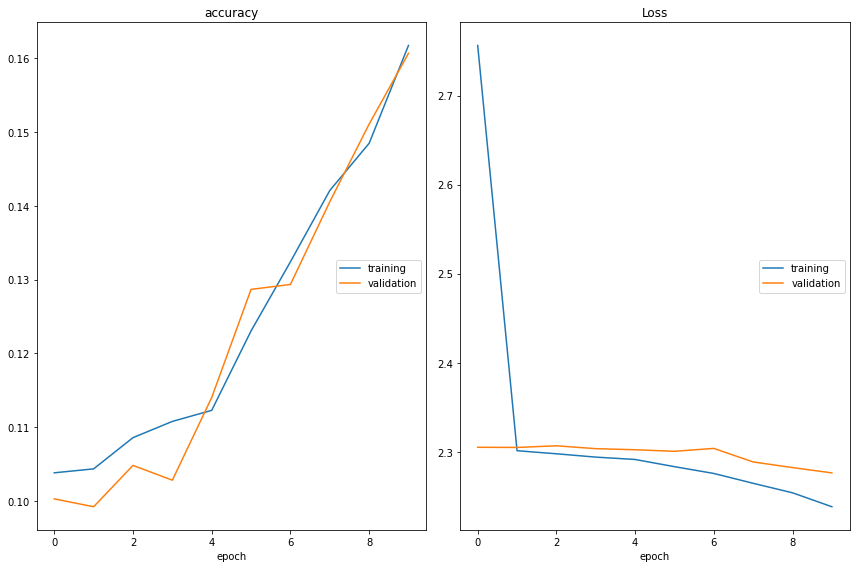

accuracy
	training         	 (min:    0.104, max:    0.162, cur:    0.162)
	validation       	 (min:    0.099, max:    0.161, cur:    0.161)
Loss
	training         	 (min:    2.238, max:    2.756, cur:    2.238)
	validation       	 (min:    2.276, max:    2.307, cur:    2.276)
235/235 [==============================] - 280s 1s/step - loss: 2.2384 - accuracy: 0.1617 - val_loss: 2.2764 - val_accuracy: 0.1607


In [11]:
# Train the VGG16 model
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
vgg16_fit = vgg16_model.fit(x_train_vgg16, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=10,# 20
                            #steps_per_epoch=1000, #1000
                            validation_split=0.2, 
                            #validation_steps=200, #200
                            callbacks=[vgg16_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [12]:
# Prediction & Accuracy
start = dt.now()
vgg16_model.load_weights('vgg16.weights.best.hdf5')
vgg16_preds = vgg16_model.predict(x_test_vgg16)
vgg16_pred_classes = np.argmax(vgg16_preds, axis=1)
vgg16_running = (dt.now() - start).microseconds
vgg16_acc = accuracy_score(y_test, vgg16_pred_classes)
print("VGG16 Model Accuracy: {:.2f}%".format(vgg16_acc * 100))

391/391 [==============================] - 101s 257ms/step
VGG16 Model Accuracy: 16.42%


In [13]:
def vgg16_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = vgg16.preprocess_input(image[np.newaxis, :])
    vgg16_model.load_weights('vgg16.weights.best.hdf5')
    vgg16_preds = vgg16_model.predict(img_mtx)
    vgg16_pred_classes = np.argmax(vgg16_preds, axis=1)
    return int(vgg16_pred_classes[0])

# vgg16_model1(imgs[1])

#### Candidate Model 2: VGG-19

In [14]:
# Preprocess input
x_train_vgg19 = vgg19.preprocess_input(x_train) 
x_test_vgg19 = vgg19.preprocess_input(x_test)

In [15]:
# Load VGG19 model
def create_model_vgg19(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = vgg19.VGG19(include_top=False,
                            weights='imagenet', 
                            input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
vgg19_model = create_model_vgg19(input_shape, n_classes, optim, fine_tune = 0)

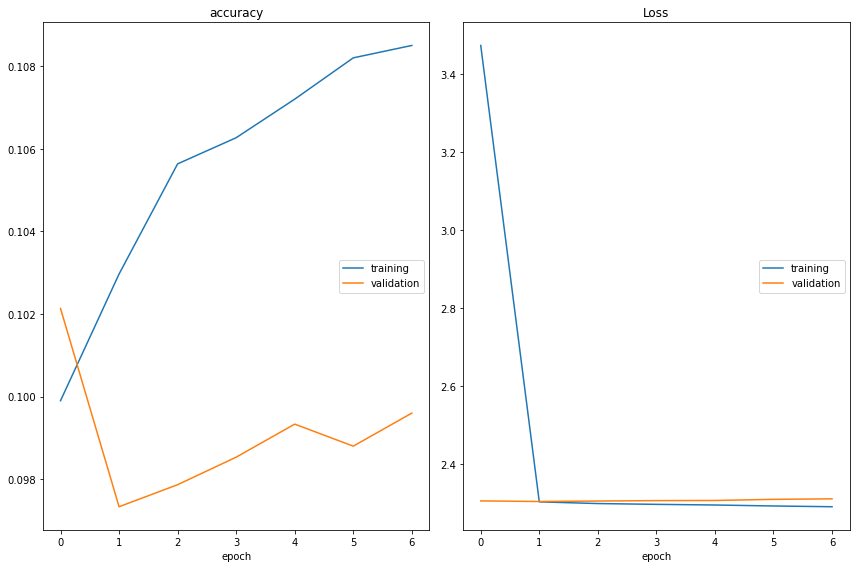

accuracy
	training         	 (min:    0.100, max:    0.108, cur:    0.108)
	validation       	 (min:    0.097, max:    0.102, cur:    0.100)
Loss
	training         	 (min:    2.290, max:    3.473, cur:    2.290)
	validation       	 (min:    2.304, max:    2.310, cur:    2.310)
235/235 [==============================] - 307s 1s/step - loss: 2.2901 - accuracy: 0.1085 - val_loss: 2.3104 - val_accuracy: 0.0996


In [16]:
# Train the VGG19 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
vgg19_checkpoint = ModelCheckpoint(filepath='vgg19.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
vgg19_fit = vgg19_model.fit(x_train_vgg19, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=10,# 20
                            #steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            #validation_steps=20, #200
                            callbacks=[vgg19_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [17]:
# Prediction & Accuracy
start = dt.now()
vgg19_model.load_weights('vgg19.weights.best.hdf5')
vgg19_preds = vgg19_model.predict(x_test_vgg19)
vgg19_pred_classes = np.argmax(vgg19_preds, axis=1)
vgg19_running = (dt.now() - start).microseconds
vgg19_acc = accuracy_score(y_test, vgg19_pred_classes)
print("VGG19 Model Accuracy: {:.2f}%".format(vgg19_acc * 100))

391/391 [==============================] - 114s 290ms/step
VGG19 Model Accuracy: 10.15%


In [18]:
def vgg19_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = vgg19.preprocess_input(image[np.newaxis, :])
    vgg19_model.load_weights('vgg19.weights.best.hdf5')
    vgg19_preds = vgg19_model.predict(img_mtx)
    vgg19_pred_classes = np.argmax(vgg19_preds, axis=1)
    return int(vgg19_pred_classes[0])

# vgg19_model1(imgs[1])

#### Candidate Model 3: ResNet Approach

In [19]:
# Preprocess input
x_train_resnet = resnet.preprocess_input(x_train) 
x_test_resnet = resnet.preprocess_input(x_test)

In [20]:
# Load ResNet model
def create_model_resnet(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = resnet.ResNet50(include_top=False,
                                weights='imagenet', 
                                input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.   
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
resnet_model = create_model_resnet(input_shape, n_classes, optim, fine_tune = 0)

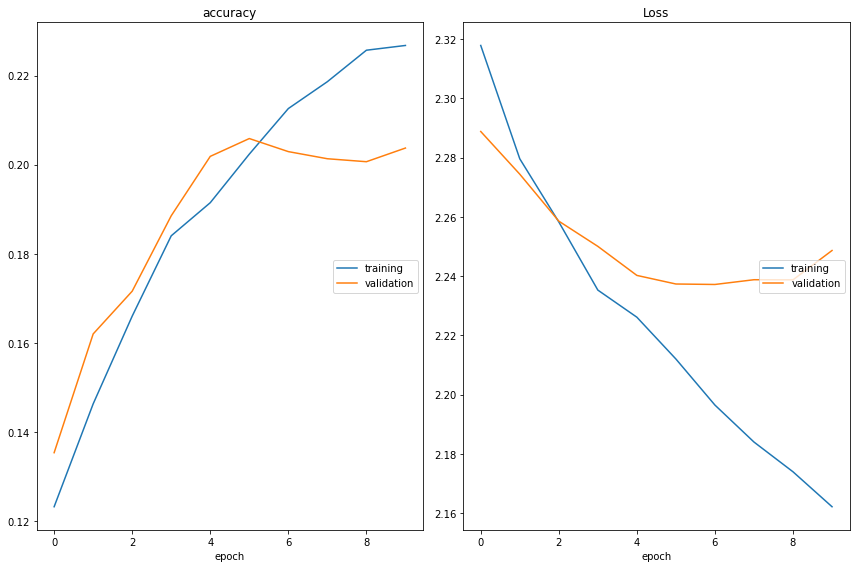

accuracy
	training         	 (min:    0.123, max:    0.227, cur:    0.227)
	validation       	 (min:    0.135, max:    0.206, cur:    0.204)
Loss
	training         	 (min:    2.162, max:    2.318, cur:    2.162)
	validation       	 (min:    2.237, max:    2.289, cur:    2.249)
235/235 [==============================] - 99s 423ms/step - loss: 2.1621 - accuracy: 0.2268 - val_loss: 2.2486 - val_accuracy: 0.2037


In [21]:
# Train the ResNet model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
resnet_checkpoint = ModelCheckpoint(filepath='resnet.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
resnet_fit = resnet_model.fit(x_train_resnet, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=10,# 20
                            #steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            #validation_steps=20, #200
                            callbacks=[resnet_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [22]:
# Prediction & Accuracy
start = dt.now()
resnet_model.load_weights('resnet.weights.best.hdf5')
resnet_preds = resnet_model.predict(x_test_resnet)
resnet_pred_classes = np.argmax(resnet_preds, axis=1)
resnet_running = (dt.now() - start).microseconds
resnet_acc = accuracy_score(y_test, resnet_pred_classes)
print("ResNet Model Accuracy: {:.2f}%".format(resnet_acc * 100))

391/391 [==============================] - 40s 100ms/step
ResNet Model Accuracy: 20.01%


In [23]:
def resnet_model1(image):
    '''
    This is the VGG16 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = resnet.preprocess_input(image[np.newaxis, :])
    resnet_model.load_weights('resnet.weights.best.hdf5')
    resnet_preds = resnet_model.predict(img_mtx)
    resnet_pred_classes = np.argmax(resnet_preds, axis=1)
    return int(resnet_pred_classes[0])

# resnet_model1(imgs[1])

#### Candidate Model 4: Inception

In [24]:
# Preprocess input
x_train_incep = inception_v3.preprocess_input(tf.image.resize(x_train,(75,75)).numpy()) 
x_test_incep = inception_v3.preprocess_input(tf.image.resize(x_test,(75,75)).numpy())

In [25]:
# Load InceptionV3 model
def create_model_incep(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = inception_v3.InceptionV3(include_top=False,
                                weights='imagenet', 
                                input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.   
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (75, 75, 3)
n_classes=10
optim = Adam(learning_rate=0.001) 
incep_model = create_model_incep(input_shape, n_classes, optim, fine_tune = 0)

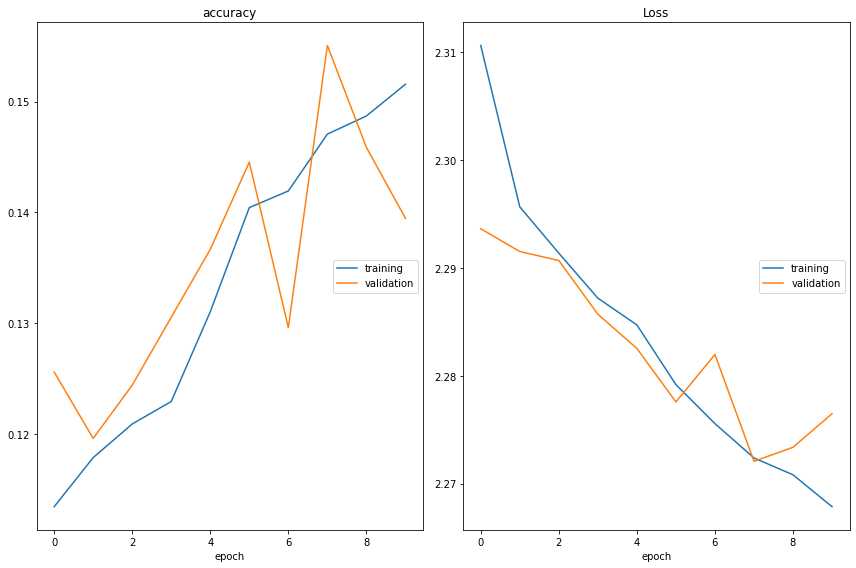

accuracy
	training         	 (min:    0.113, max:    0.152, cur:    0.152)
	validation       	 (min:    0.120, max:    0.155, cur:    0.139)
Loss
	training         	 (min:    2.268, max:    2.311, cur:    2.268)
	validation       	 (min:    2.272, max:    2.294, cur:    2.276)
235/235 [==============================] - 201s 855ms/step - loss: 2.2679 - accuracy: 0.1516 - val_loss: 2.2765 - val_accuracy: 0.1395


In [26]:
# Train the InceptionV3 model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
incep_checkpoint = ModelCheckpoint(filepath='incep.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()
incep_fit = incep_model.fit(x_train_incep, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=10,# 20
                            #steps_per_epoch=1000, #1000
                            validation_split=0.2, 
                            #validation_steps=20, #200
                            callbacks=[incep_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [27]:
# Prediction & Accuracy
start = dt.now()
incep_model.load_weights('incep.weights.best.hdf5')
incep_preds = incep_model.predict(x_test_incep)
incep_pred_classes = np.argmax(incep_preds, axis=1)
inc_running = (dt.now() - start).microseconds
incep_acc = accuracy_score(y_test, incep_pred_classes)
print("Inception Model Accuracy: {:.2f}%".format(incep_acc * 100))

391/391 [==============================] - 76s 189ms/step
Inception Model Accuracy: 15.41%


In [28]:
def incep_model1(image):
    '''
    This is the InceptionV3 predictive model that takes in the image and returns a label prediction
    '''
    img_mtx = inception_v3.preprocess_input(tf.image.resize(image[np.newaxis, :],(75,75)).numpy()) 
    incep_model.load_weights('incep.weights.best.hdf5')
    incep_preds = incep_model.predict(img_mtx)
    incep_pred_classes = np.argmax(incep_preds, axis=1)
    return int(incep_pred_classes[0])

# incep_model1(imgs[1])

#### Candidate Model 5: SVM

In [29]:
# Split the training & test set using features
x_train, x_test, y_train, y_test = train_test_split(feature_mtx, target_vec, test_size = 0.25, random_state = 42)

In [30]:
# GridSearch for best parameters
# param_grid = {'C': [0.1, 1, 10, 100], 
#              'gamma': [1, 0.1, 0.01, 0.001]} 
  
# grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=3)
  
# fitting the model for grid search
# grid.fit(x_train, y_train)
# print(grid.best_params_)
# print(grid.best_estimator_)

In [31]:
# Train the SVM model
svm_rbf = SVC(C=10, gamma=0.001, kernel='rbf')
svm_rbf.fit(x_train, y_train);

In [32]:
# Prediction & Accuracy
# svm_rbf.score(x_train, y_train)
start = dt.now()
svm_rbf_pred_classes = []
for x in x_test:
    svm_rbf_pred_classes.append(svm_rbf.predict(x.reshape(1, -1))[0])
svm_running = (dt.now() - start).microseconds
print("SVM Model Prediction Time Cost: {:.0f}s".format(svm_running))
svm_rbf_acc = svm_rbf.score(x_test, y_test)
print("SVM Model Accuracy: {:.2f}%".format(svm_rbf_acc * 100))

SVM Model Prediction Time Cost: 743364s
SVM Model Accuracy: 10.02%


In [33]:
def svm_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return svm_rbf.predict(feature.reshape(1,-1))

#### Candidate Model 6: KNN

In [34]:
# GridSearch for best parameters
# knn = KNeighborsClassifier()
# k_range = list(range(1, 31))
# param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
  
# fitting the model for grid search
# grid_search=grid.fit(x_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_estimator_)

In [35]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=27)

In [36]:
# Prediction & Accuracy
# knn.score(x_train, y_train)
start = dt.now()
knn_pred_classes = []
for x in x_test:
    knn_pred_classes.append(knn.predict(x.reshape(1, -1))[0])
knn_running = (dt.now() - start).microseconds
print("KNN Model Prediction Time Cost: {:.0f}s".format(knn_running))
knn_acc = knn.score(x_test, y_test)
print("KNN Model Accuracy: {:.2f}%".format(knn_acc * 100))

KNN Model Prediction Time Cost: 573771s
KNN Model Accuracy: 13.70%


In [37]:
def knn_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return knn.predict(feature.reshape(1,-1))

#### Candidate Model 7: Random Forest

In [38]:
# GridSearch for best parameters
# rfc = RandomForestRegressor()

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_depth' : [4,5,6,7,8]
# }

# rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# rfc_grid = rfc.fit(x_train, y_train)
# print(rfc_grid.best_estimator_)

In [39]:
# Train the Random Forest model
rfc = RandomForestClassifier(max_depth=8, n_estimators=500)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500)

In [40]:
# Prediction & Accuracy
# rfc.score(x_train, y_train)
start = dt.now()
rfc_pred_classes = []
for x in x_test:
    rfc_pred_classes.append(rfc.predict(x.reshape(1, -1))[0])
rfc_running = (dt.now() - start).microseconds
print("Random Forest Model Prediction Time Cost: {:.0f}s".format(rfc_running))
rfc_acc = rfc.score(x_test, y_test)
print("Random Forest Model Accuracy: {:.2f}%".format(rfc_acc * 100))

Random Forest Model Prediction Time Cost: 890200s
Random Forest Model Accuracy: 16.26%


In [41]:
def rfc_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return rfc.predict(feature.reshape(1,-1))

#### Candidate Model 8: Boosting

In [42]:
# GridSearch for best parameters
# gbc = GradientBoostingClassifier()

# param_grid = { 
#     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
# }

# gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5)
# gbc_grid = gbc.fit(x_train, y_train)

# print(gbc_grid.best_params_)

In [43]:
# Train the Boosting model
gbc = GradientBoostingClassifier(learning_rate=0.1)
gbc.fit(x_train, y_train)

GradientBoostingClassifier()

In [44]:
# Prediction & Accuracy
# gbc.score(x_train, y_train)
start = dt.now()
gbc_pred_classes = []
for x in x_test:
    gbc_pred_classes.append(gbc.predict(x.reshape(1, -1))[0])
gbc_running = (dt.now() - start).microseconds
print("Boosting Model Prediction Time Cost: {:.0f}s".format(gbc_running))
gbc_acc = gbc.score(x_test, y_test)
print("Boosting Model Accuracy: {:.2f}%".format(gbc_acc * 100))

Boosting Model Prediction Time Cost: 656709s
Boosting Model Accuracy: 16.18%


In [45]:
def gbc_model1(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return gbc.predict(feature.reshape(1,-1))

#### Candidate Model 9: MobileNetV3

In [46]:
# Split the data into training set (75%) and test set (25%)
x_train, x_test, y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.25, random_state = 42)

# Preprocess input
x_train_vgg19 = vgg19.preprocess_input(x_train) 
x_test_vgg19 = vgg19.preprocess_input(x_test)

# Transform labels to correct format
y_train_vec = to_categorical(y_train, num_classes=10)
y_test_vec = to_categorical(y_test, num_classes=10)

In [47]:
# Load mnv3 model
def create_model_mnv3(input_shape, n_classes, optimizer, fine_tune):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
               If set to 0, all pretrained layers will freeze during training
    """
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = MobileNetV3Small(include_top=False,
                            weights='imagenet',input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    # If the arg fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers) 
    # by grabbing the conv_base outputs and flattening them.
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model)
    top_model = Dense(n_classes*4, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model) 
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (32, 32,3)
n_classes=10
optim = Adam(learning_rate=0.001) 
mnv3_model = create_model_mnv3(input_shape, n_classes, optim, fine_tune = 0)

In [48]:
mnv3_checkpoint = ModelCheckpoint(filepath='mnv3.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()

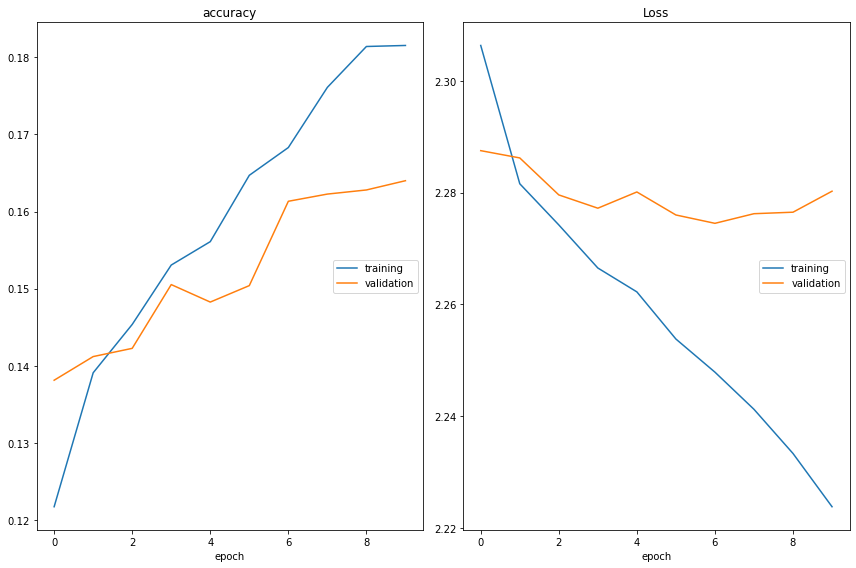

accuracy
	training         	 (min:    0.122, max:    0.182, cur:    0.182)
	validation       	 (min:    0.138, max:    0.164, cur:    0.164)
Loss
	training         	 (min:    2.224, max:    2.306, cur:    2.224)
	validation       	 (min:    2.274, max:    2.288, cur:    2.280)
235/235 [==============================] - 15s 64ms/step - loss: 2.2238 - accuracy: 0.1815 - val_loss: 2.2803 - val_accuracy: 0.1640


In [49]:
mnv3_fit = mnv3_model.fit(x_train_vgg19, 
                            y_train_vec,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=10,# 20
                            #steps_per_epoch=100, #1000
                            validation_split=0.2, 
                            #validation_steps=20, #200
                            callbacks=[mnv3_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [50]:
# Prediction & Accuracy
start = dt.now()
mnv3_model.load_weights('mnv3.weights.best.hdf5')
mnv3_preds = mnv3_model.predict(x_test_vgg19)
mnv3_pred_classes = np.argmax(mnv3_preds, axis=1)
mnv3_running = (dt.now() - start).microseconds
mnv3_acc = accuracy_score(y_test, mnv3_pred_classes)
print("mnv3 Model Accuracy: {:.2f}%".format(mnv3_acc * 100))

391/391 [==============================] - 7s 16ms/step
mnv3 Model Accuracy: 16.23%


#### Model I Comparison

In [55]:
# Accuracy & Time Cost table for all candidate models
model1_accuracy = np.array([['VGG16', 'VGG19', 'ResNet', 'Inception', 'MobileNet','SVM', 'KNN', 'RandomForest', 'GBC'], 
                            [vgg16_acc, vgg19_acc, incep_acc, resnet_acc, mnv3_acc, svm_rbf_acc, knn_acc, rfc_acc, gbc_acc],
                            [vgg16_running, vgg19_running, mnv3_running, inc_running, resnet_running, svm_running, knn_running, rfc_running, gbc_running]])

evaluation_df = pd.DataFrame(data=model1_accuracy.T, columns=['Models', 'Accuracy','Predict Time (ms)'])
evaluation_df = evaluation_df.sort_values(by = 'Accuracy', ascending = False)
evaluation_df

,Models,Accuracy,Predict Time (ms)
3,Inception,0.20008,360167
0,VGG16,0.16424,732811
7,RandomForest,0.16264,890200
4,MobileNet,0.16232,83246
8,GBC,0.16184,656709
2,ResNet,0.15408,876388
6,KNN,0.13704,573771
1,VGG19,0.10152,400932
5,SVM,0.10024,743364


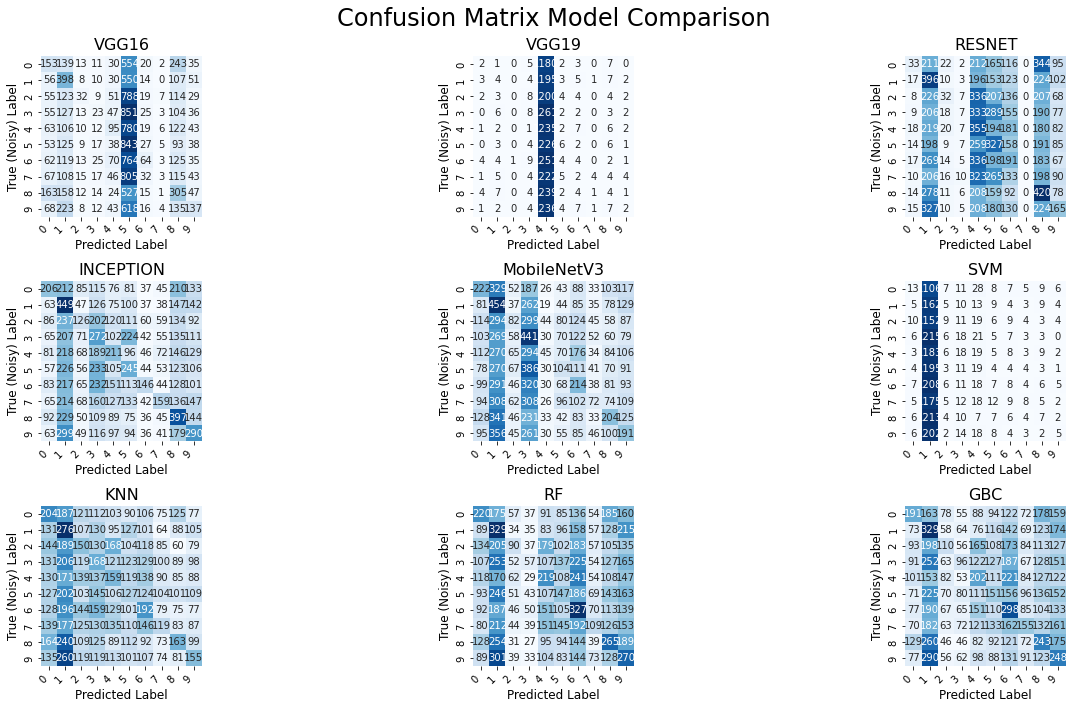

In [57]:
# Confusion matrix for all candidate models
class_names = [x for x in range(0, 10)] 

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True (Noisy) Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(3, 3, figsize=(20, 10))
   
plot_heatmap(y_test, vgg16_pred_classes, class_names, ax1, title="VGG16")    
plot_heatmap(y_test, vgg19_pred_classes, class_names, ax2, title="VGG19")    
plot_heatmap(y_test, incep_pred_classes, class_names, ax3, title="RESNET")    
plot_heatmap(y_test, resnet_pred_classes, class_names, ax4, title="INCEPTION") 
plot_heatmap(y_test, mnv3_pred_classes, class_names, ax5, title="MobileNetV3")  
plot_heatmap(y_test, svm_rbf_pred_classes, class_names, ax6, title="SVM")    
plot_heatmap(y_test, knn_pred_classes, class_names, ax7, title="KNN") 
plot_heatmap(y_test, rfc_pred_classes, class_names, ax8, title="RF")    
plot_heatmap(y_test, gbc_pred_classes, class_names, ax9, title="GBC") 
  

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
plt.show()